## Image Segmentation

Import matplotlib

In [198]:
import matplotlib.pyplot as plt

In [199]:
import cv2
im=cv2.imread('./IMG.JPG')

Use cvtColor to convert the image to the BGR2RGB color space.

In [200]:
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#plt.imshow(im)

(4000, 6000, 3)


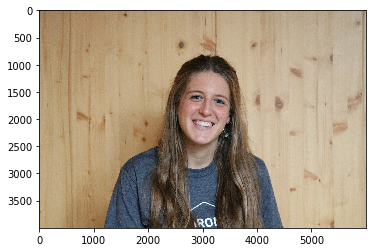

In [4]:
pic = plt.imread('./IMG.JPG')/255  # dividing by 255 to bring the pixel values between 0 and 1
print(pic.shape)
plt.imshow(pic)


In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import torch

In [6]:
from torchvision import models
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

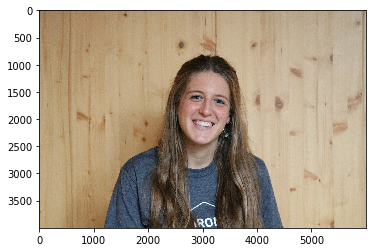

(6000, 4000)


In [7]:
# !wget -nv https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg -O bird.png
img = Image.open('./IMG.JPG')
plt.imshow(img); plt.show()
print(img.size)

In [8]:
# Apply the transformations needed
import torchvision.transforms as T
trf = T.Compose([T.Resize(500),
                 T.CenterCrop(500),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0)

In [9]:
out = fcn(inp)['out']
print (out.shape)

torch.Size([1, 21, 500, 500])


In [10]:
import numpy as np
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)

(500, 500)


In [11]:
# Define the helper function
def decode_segmap(image, nc=21):
   
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
 
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
   
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
     
  rgb = np.stack([r, g, b], axis=2)
  return rgb

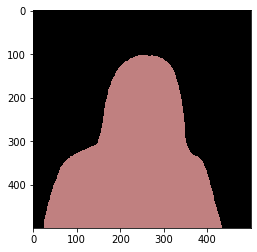

In [12]:
rgb = decode_segmap(om)
plt.imshow(rgb); plt.show()

In [13]:
### 

In [14]:
def segment(net, path):
    img = Image.open(path)
    t=T.Compose([T.Resize(512)])
    img=t(img)
    plt.imshow(img); plt.axis('off'); plt.show()
    # Comment the Resize and CenterCrop for better inference results
    trf = T.Compose([T.ToTensor(), 
                     T.Normalize(mean = [0.485, 0.456, 0.406], 
                                 std = [0.229, 0.224, 0.225])])
    inp = trf(img).unsqueeze(0)
    out = net(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    rgb = decode_segmap(om)
    plt.imshow(rgb); plt.axis('off'); plt.show()
    return img, rgb

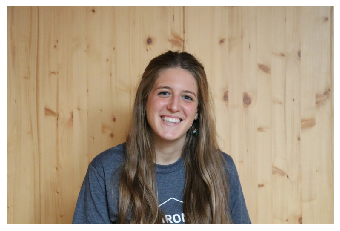

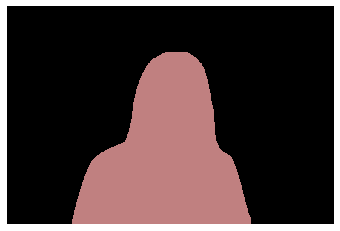

In [15]:
#!wget -nv https://images.pexels.com/photos/1996333/pexels-photo-1996333.jpeg -O horse.png
img, rgb=segment(fcn, './IMG.JPG')

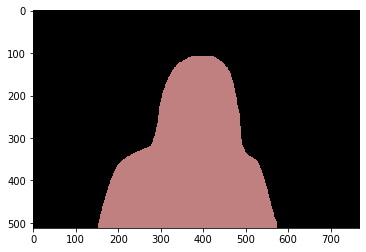

In [16]:
plt.imshow(rgb)

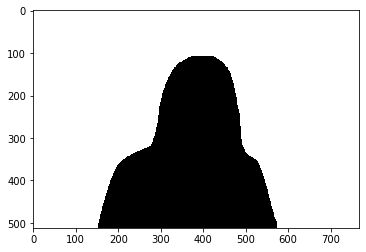

In [17]:
image_copy = rgb.copy()

black_pixels_mask = np.all(rgb == [0, 0, 0], axis=-1)

non_black_pixels_mask = np.any(rgb != [0, 0, 0], axis=-1)  
# or non_black_pixels_mask = ~black_pixels_mask

image_copy[black_pixels_mask] = [255, 255, 255]
image_copy[non_black_pixels_mask] = [0, 0, 0]

plt.imshow(image_copy)
plt.show()

In [55]:
img_np_front = np.array(img)

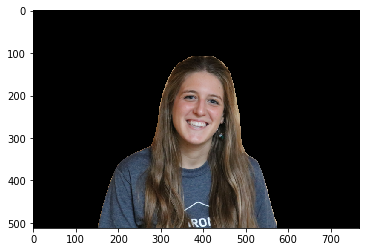

In [56]:
img_np_front[black_pixels_mask] = [0, 0, 0]
plt.imshow(img_np_front)

(512, 768, 3)


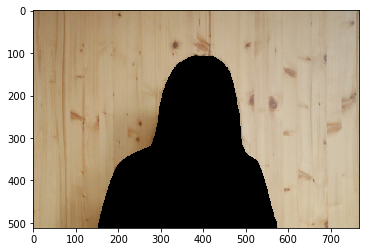

In [57]:
img_np_back = np.array(img)
img_np_back[non_black_pixels_mask] = [0, 0, 0]
print(img_np_back.shape)
plt.imshow(img_np_back)

In [60]:
import scipy.signal
import numpy as np

In [62]:
r,g,b = img_np_back[:,:,0],img_np_back[:,:,1],img_np_back[:,:,2]

In [63]:
r.shape

(512, 768)

In [64]:
img_np_2gray = cv2.cvtColor(img_np_back, cv2.COLOR_BGR2GRAY)

In [65]:
img_np_2gray.shape

(512, 768)

In [177]:
#mat1=np.random.random((512,768))
mat1=np.random.random((20,20))

In [178]:
rgb = []
for channel in [r,g,b]:
    rgb.append(scipy.signal.convolve2d(channel,mat1,mode='same',boundary='symm'))

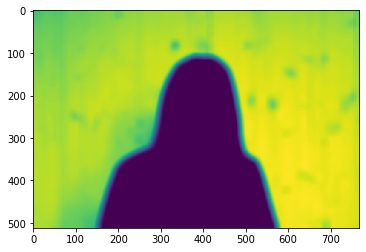

In [179]:
plt.imshow(rgb[0])

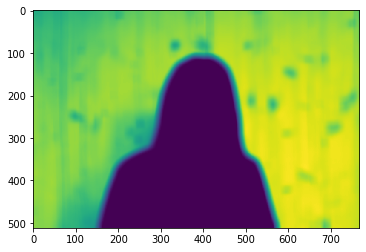

In [180]:
plt.imshow(rgb[1])

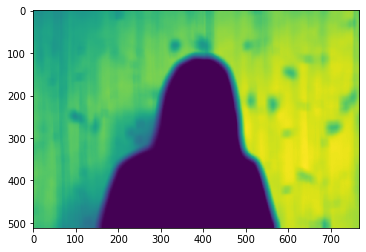

In [181]:
plt.imshow(rgb[2])

In [182]:
filtered_rgb=[]
for grad in rgb:
    filtered_rgb.append(np.absolute(grad))


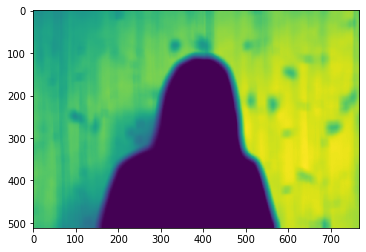

In [183]:
plt.imshow(filtered_rgb[2])

In [184]:
filtered_img=np.stack(filtered_rgb,axis=-1)

In [186]:
filtered_img.shape

(512, 768, 3)

In [187]:
np.max(filtered_img)

42692.6983450435

In [188]:
num_div=np.max(filtered_img)/255
filtered_img=(filtered_img/num_div).astype(int)
np.max(filtered_img)

255

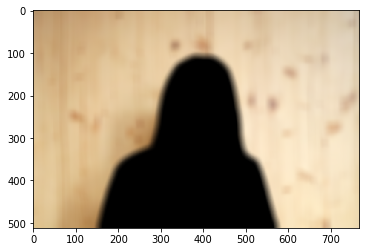

In [189]:
plt.imshow(filtered_img)

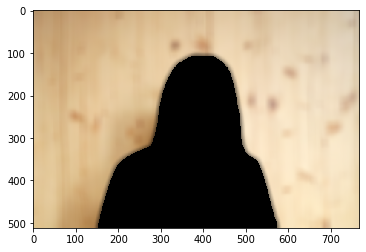

In [191]:
img_filtered = np.array(filtered_img)
img_filtered[non_black_pixels_mask] = 0
plt.imshow(img_filtered)

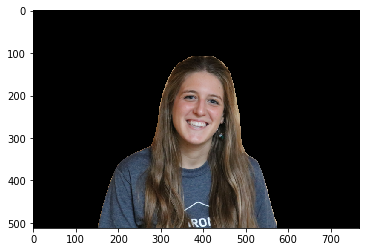

In [195]:
plt.imshow(img_np_front)

In [196]:
final=np.add(img_filtered,img_np_front)

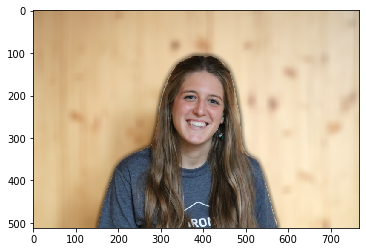

In [197]:
plt.imshow(final)